In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import powerlaw
from tree import Tree
from fire import Fire
from forest import Forest
from analysis import Analyse

Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Assuming nested distributions
c:\Users\user\anaconda3\lib\site-packages\powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
c:\Users\user\anaconda3\lib\site-packages\powerlaw.py:1408: RuntimeWarning: overflow encountered in scalar power
  C = ( self.Lambda**(1-self.alpha) /
c:\Users\user\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
c:\Users\user\anaconda3\lib\site-packages\powerlaw.py:1396: RuntimeWarning: overflow encountered in scalar power
  self.Lambda**(1-self.alpha)
c:\Users\user\anaconda3\lib\site-packages\powerlaw.py:1808: RuntimeWarning: invalid value encountered in subtract
  ( (loglikelihood

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit

Assuming nested distributions


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Calculating best minimal value for power law fit


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Assuming nested distributions


None


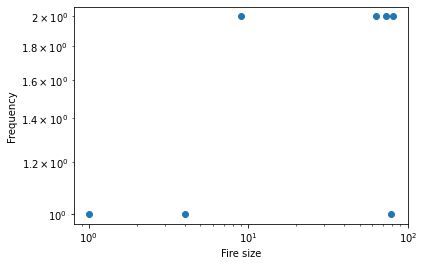

In [5]:
L = 10
g = 1
f = 50
timesteps = 10**3
instances = 10
analysis_exp =  Analyse(L, g, f, timesteps, instances)
analysis_exp.run_all()
print(analysis_exp.find_proportion_power_law())
analysis_exp.log_log_plot(3)